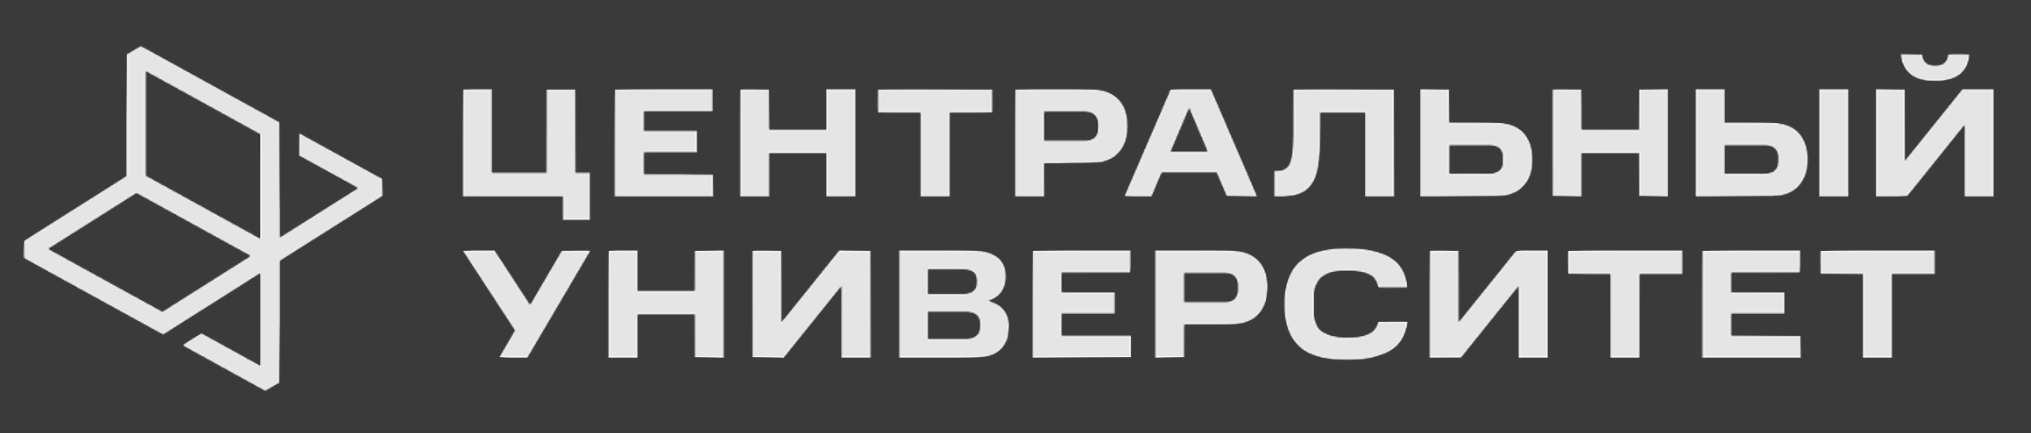

# Домашнее задание 8. Generative models.

## Максимальное кол-во баллов: 100

___
## Cроки

Дата выдачи: TBD

Жесткий дедлайн: TBD



---

# Важно! О формате сдачи

* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**
*  **Если в ячейке написана фраза "Вывод"/"Ответ на вопрос"/"Ваш текст" и пр., то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно).**
* **Если в ячейке написано "Your code here"/"Ваш код" и пр., то ожидается ответ в виде кода (можете добавить больше ячеек с кодом, если считаете это необходимым, но это необязательно).**
* **Если есть и ячейка с фразой "Вывод" и пр., и ячейка с фразой "Your code here" и пр., то в ответе ожидается и код, и текст)**
* **Если в формулировке задания явно не указывается сигнатура функции, можно пользоваться своими методами**
___


Привет! В этой домашке тебе предстоит подчинить себе генерацию, а именно реализовать conditional-варианты архитектур VAE/GAN

**Важно**:
1. архитектуры должны быть реализованы при помощи сверточных слоев `nn.Conv2d`, решения без сверток засчитываться не будут, но можно добавлять `nn.Linear` по необходимости
2. чекпоинты, ноутбук и используемые модули(архитектуры рекомендуется разбить на модули для читаемости) должны быть прикреплены к решению
3. можешь оставить requirements.txt чтобы облегчить проверяющим жизнь

---

## <font color='orange'>Задание 0: Данные [5 баллов]</font>

Работать будем с хорошо известным вам датасетом циферок, ниже его надо будет скачать при помощи `torchvision API`

![](https://user-images.githubusercontent.com/47734496/60438108-8b894000-9c2d-11e9-9cbb-1c06e3fb90a7.png)

Размер картинок: 28x28x1, трейн/тест сплиты: 60000, 10000

Лики данных допустимы, можете использовать все данные как трейн, только оставьте какую-то часть на валидацию(понадобится для графиков функций потерь)

---

### 0.1. [5 баллов]
### Формулировка задания:

1. Визуализируй семплы из датесетов для твоего:
- трейна
- инференса
2. Выведи размеры train/val сплитов


Нормализовывать картинки не обязательно, используй референсы ниже как пример

In [1]:
import torchvision.transforms as TT
import torch

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.01):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

train_transforms = TT.Compose([
    # TT.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    TT.ToTensor(),
    # TT.Normalize(0.5, 0.5),
    # AddGaussianNoise(),
])
val_transforms = TT.Compose([
    TT.ToTensor(),
    # TT.Normalize(0.5, 0.5)
])

In [2]:
from torchvision.datasets import MNIST

train_dataset = MNIST(root='mnist_dataset', train=True, transform=train_transforms, download=True)
val_dataset = MNIST(root='mnist_dataset', train=False, transform=val_transforms, download=True)

len(train_dataset), len(val_dataset)

(60000, 10000)

In [3]:
import matplotlib.pyplot as plt
import math

def show_transforms(dataset, num_images):
    num_rows = math.ceil(num_images / 10)
    fig, axes = plt.subplots(num_rows, 10)
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    for i, axis in enumerate(axes.flat):
        if i < num_images:
            axis.imshow(dataset[i][0][0], cmap = 'gray')
            axis.set_title(f'{dataset[i][1]}')
        axis.axis('off')
    plt.tight_layout()
    plt.show()

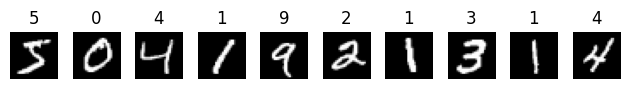

In [5]:
show_transforms(train_dataset, num_images=10)

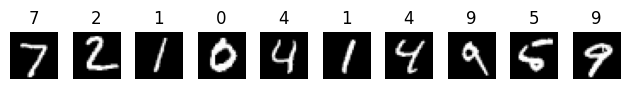

In [6]:
show_transforms(val_dataset, num_images=10)

---

## <font color='orange'>Задание 1: Conditional VAE [45 баллов] + 5 баллов за функцию метрики</font>

![](https://drive.google.com/uc?export=view&id=1-GQwHMBFpY8W1hiOO_yuIOh8yfcAox6D)

![](https://drive.google.com/uc?export=view&id=1DIAUPy88plSiuA8n9ElkLnmg8nTd-vuH)

Note: подумай как еще можно закодировать лейблы с помощью `nn.Embedding` вместо `one-hot`-представления. Скорее всего, так будет лучше учиться

---

### 1.1. [10 баллов]
### Формулировка задания:

Реализуй conditional-автоэнкодер, можешь использовать картинку выше как референс, не запрещается использовать более интересные подходы

Артефактом к данному пункту будет служить модуль с автоэнкодером или клетка с объявлением класса

In [4]:
import torch.nn as nn

class CVAE(nn.Module):
    def __init__(self, num_classes, emb_size, latent_dim):
        super(CVAE, self).__init__()
        self.num_classes = num_classes
        self.emb_size = emb_size
        self.latent_dim = latent_dim

        self.embedding = nn.Embedding(num_classes, emb_size)

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1, stride=2), # (16, 14, 14)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2), # (32, 6, 6)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 2), # (64, 5, 5)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten() # 1600
        )
        self.enc_out = len(self.encoder(torch.randn(1, 1, 28, 28))[0])
        self.fc_mu = nn.Linear(self.enc_out + emb_size, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_out + emb_size, latent_dim)
        self.fc_decoder = nn.Linear(latent_dim + emb_size, self.enc_out)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2), # (32, 6, 6)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2), # (16, 14, 14)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1), # (1, 28, 28)
            nn.Sigmoid()
        )
        
    def encode(self, x, labels):
        h = self.encoder(x)
        embedded_labels = self.embedding(labels)
        h = torch.cat([h, embedded_labels], dim=1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z, labels):
        embs = self.embedding(labels)
        z = torch.cat([z, embs], dim=1)
        h = self.fc_decoder(z)
        h = h.view(-1, 64, 5, 5)
        return self.decoder(h)

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparametrize(mu, logvar)
        return self.decode(z, labels), mu, logvar

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

---

### 1.2. [5 баллов]
### Формулировка задания:

Обучи модель и визуализируй историю лоссов по эпохам на train/val сплитах(вторая картинка на референсе необязательная)

Должно получиться что-то похожее на референсную картинку ниже

Артефакт: веса обученной модели

In [8]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [6]:
def generate_samples(model, labels, latent_dim, num_samples=10):
    model.eval()
    with torch.no_grad():
        labels = labels.to(device)
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z, labels).cpu()
        return samples

In [520]:
from IPython.display import clear_output

def train_autoencoder(epochs=20, latent_dim=3, emb_size=10):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = CVAE(latent_dim=latent_dim, num_classes=10, emb_size=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    def train(epoch):
        model.train()
        train_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data, labels)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_idx, (data, labels) in enumerate(val_loader):
                data = data.to(device)
                labels = labels.to(device)
                recon_batch, mu, logvar = model(data, labels)
                loss = loss_function(recon_batch, data, mu, logvar)
                val_loss += loss.item()
        
        return train_loss / len(train_loader.dataset), val_loss / len(val_loader.dataset), model

    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        tr_loss, val_loss, model = train(epoch)
        train_losses.append(tr_loss)
        val_losses.append(val_loss)

        plt.figure(figsize=(4, 4))
        plt.plot(np.arange(epoch + 1), np.array(train_losses), label='train_loss')
        plt.plot(np.arange(epoch + 1), np.array(val_losses), label='val_loss')
        plt.legend()
        plt.show()
        
        model.eval()
        with torch.no_grad():
            labels = torch.arange(10).long()
            samples = generate_samples(model, labels, latent_dim)
            fig, axes = plt.subplots(1, 10, figsize=(10, 1))
            for i, ax in enumerate(axes):
                ax.imshow(samples[i].view(28, 28).numpy(), cmap='gray')
                ax.axis('off')
            # plt.show()
            plt.tight_layout()
            plt.show()
        clear_output(wait=True)
    return model

In [12]:
LATENT_DIM = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {'epochs': 17, 'latent_dim': LATENT_DIM}

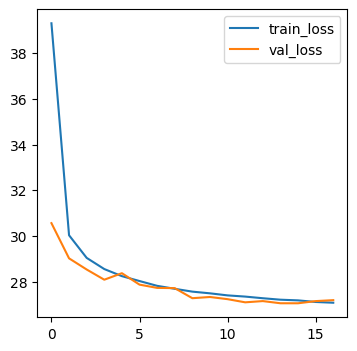

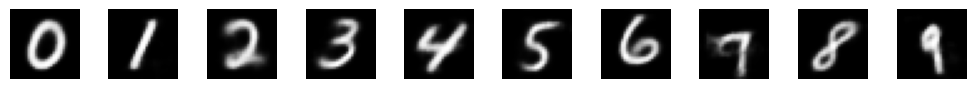

In [521]:
model = train_autoencoder(
    **config
)

In [518]:
torch.save(model.state_dict(), 'cvae.ckpt')

---

### 1.3. [5 баллов]
### Формулировка задания:

1. Реализуй функцию `show_grid_vae(...)`, используя шаблон ниже

2. Визуализируй результат для `digit=4, n_reps=9`

3. Добавь код загрузки весов обученной модели, чтобы проверяющему было удобно воспроизвести твой код

In [7]:
@torch.no_grad
def show_grid_vae(model=None, digit=0, n_reps=1, device=None):
    """
    Визуализатор семлов CVAE.
            Параметры:
                    model torch.nn.Module: модель CVAE
                    digit (int): генерируемая цифра
                    n_reps (int): кол-во семплов
                    device torch.device: девайс
            Возвращаемое значение:
                    None
    """

    model.eval()
    with torch.no_grad():
        labels = torch.tensor([digit] * n_reps)
        num_rows = math.ceil(len(labels) / 3)
        fig, axes = plt.subplots(num_rows, 3)
        if num_rows == 1:
            axes = axes.reshape(1, -1)
        samples = generate_samples(model.to(device), labels.to(device), LATENT_DIM, num_samples=n_reps)
        for i, ax in enumerate(axes.flat):
            if i < len(labels):
                ax.imshow(samples[i].view(28, 28).numpy(), cmap='gray')
            ax.axis('off')
        # plt.show()
        plt.tight_layout()
        plt.show()

Пример:

In [10]:
checkpoint = torch.load('cvae.ckpt', map_location='cpu')

model = CVAE(latent_dim=LATENT_DIM, num_classes=10, emb_size=10)
model.load_state_dict(checkpoint)

/tmp/ipykernel_280368/3905295877.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('cvae.ckpt', map_location='cpu')


<All keys matched successfully>

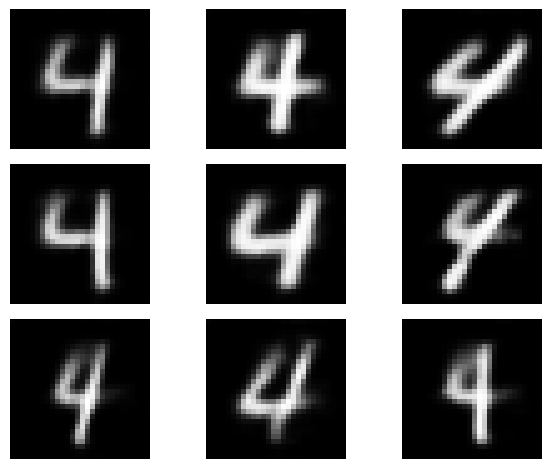

In [30]:
show_grid_vae(
    model=model,
    digit=4,
    n_reps=9,
    device=device
)

---

### 1.4. [25 баллов] + 5 баллов за корректную реализацию функции из п.п. 1
### Формулировка задания:

1. Реализуй функцию `compute_acc_vae(...)`, используя шаблон ниже

2. Выведи результат для `n_reps=100`

Итоговый балл за этот пункт рассчитывается по формуле:

- int(mean_acc * 25), где mean_acc лежит в [0, 1]


In [15]:
import torchvision.transforms as TT
from lenet import LeNet5
import torch
import numpy as np

classiffier_model = LeNet5().eval()
classiffier_model.load_state_dict(torch.load('weights/lenet_epoch=12_test_acc=0.991.pth', weights_only=True))
classiffier_model = classiffier_model.to(device)

transform = TT.Compose([
    TT.Resize(size=(32, 32), antialias=True)
])

In [16]:
@torch.no_grad
def compute_acc_vae(model=None, n_reps=1, device=device):
    """
    CVAE accuracy.
    Алгоритм:
        1. цикл по цифрам
            a. генерируем n_reps цифр с одинаковым лейблом D
            b. считаем accuracy классификатора classiffier_model (в идеале все предикты должны быть D)
            с. сохраняем результат усредненной метрики в буфер

        2. Считаем (mean, std) для получившегося буфера
        3. Возвращаем (mean, std)

            Параметры:
                    model torch.nn.Module: модель CVAE
                    n_reps (int): кол-во семплов
                    device torch.device: девайс
            Возвращаемое значение:
                    (mean, std) (float, float) рассчитаные по цифрам
    """
    model = model.to(device)
    acc = []
    for digit in range(10):
        labels = torch.tensor([digit] * n_reps)
        model.eval()
        labels = labels.to(device)
        z = torch.randn(n_reps, LATENT_DIM).to(device)
        samples = model.decode(z, labels).cpu()
        preds = classiffier_model(transform(samples.to(device)))
        acc.append((sum(preds.argmax(1) == digit) / n_reps).cpu())
    acc = np.array(acc)
    return acc.mean(), acc.std()

In [553]:
mu, sigma = compute_acc_vae(
    model=model,
    n_reps=100,
    device=device
)
mu, sigma

(1.0, 0.0)

---

## <font color='orange'>Задание 2: Conditional GAN [45 баллов]</font>

![](https://drive.google.com/uc?export=view&id=1k0C7KI6hOrCuOpa4UmZMNPy2wnjZpaBO)

---

### 2.1. [10 баллов]
### Формулировка задания:

Реализуй conditional-GAN, можешь использовать картинку выше как референс, не запрещается использовать более интересные подходы

Артефактом к данному пункту будет служить модуль с автоэнкодером или клетка с объявлением класса

In [ ]:
def denorm(image):
    return image * 0.5 + 0.5

In [31]:
def generate_samples(model, labels, noise = None, latent_dim = None, num_samples=10):
    model.eval()
    with torch.no_grad():
        labels = labels.to(device)
        if noise is None:
            if latent_dim is None:
                raise AttributeError('latent_dim is None')
            noise = torch.randn(num_samples, latent_dim)
        samples = model(noise.to(device), labels).cpu()
        return samples

In [32]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [33]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid,save_image
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST(root='./data', train=True,
                                    download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size,
                                      shuffle=True)

In [34]:
class GenBlock(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0, last = False):
        super(GenBlock, self).__init__()
        if last:
            self.block = nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.Tanh()
            )
        else:
            self.block = nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.ReLU()
            )
    def forward(self, x):
        return self.block(x)

class Generator(nn.Module):
    def __init__(self, latent_dim, emb_dim, n_classes = 10):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.emb_dim = emb_dim

        self.embedding = nn.Embedding(n_classes, emb_dim)

        self.model = nn.Sequential(
            GenBlock(latent_dim + emb_dim, 256, 3, 2),
            GenBlock(256, 128, 4, 1),
            GenBlock(128, 64, 3, 2),
            GenBlock(64, 1, 4, 2, last=True)
        )
    def forward(self, x, labels):
        emb = self.embedding(labels)
        z = torch.cat([x, emb], 1)
        z = z.view(len(x), self.emb_dim + self.latent_dim, 1, 1)
        return self.model(z)

In [35]:
class CriticBlock(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0, last = False):
        super(CriticBlock, self).__init__()
        if last:
            self.block = nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding)
            )
        else:
            self.block = nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2)
            )
    def forward(self, x):
        return self.block(x)


class Critic(nn.Module):
    def __init__(self, emb_dim, n_classes = 10):
        super(Critic, self).__init__()
        self.embedding = nn.Embedding(n_classes, emb_dim)
        self.model = nn.Sequential(
            CriticBlock(emb_dim + 1, 64, 4, 2),
            CriticBlock(64, 128, 4, 2),
            CriticBlock(128, 1, 4, 2, last=True)
        )
    def forward(self, x, labels):
        emb = self.embedding(labels)[:, :, None, None].repeat(1, 1, 28, 28)
        z = torch.cat([x, emb], 1)
        return self.model(z)

---

### 2.2. [5 баллов]
### Формулировка задания:

Обучи модель и визуализируй историю лоссов генератора и дискриминатора по эпохам(вторая и третья картинки на референсе необязательные)

Должно получиться что-то похожее на референсную картинку ниже

Артефакт: веса обученной модели

In [941]:
from IPython.display import clear_output
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np

def train_gan(epochs, lr, latent_dim):    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    b1 = 0.5
    b2 = 0.9
    loss_fn = nn.BCEWithLogitsLoss()
    
    gen = Generator(latent_dim, emb_dim=10).to(device)
    critic = Critic(emb_dim=10).to(device)
    opt_g = optim.Adam(gen.parameters(), lr=lr, betas=(b1, b2))
    opt_d = optim.Adam(critic.parameters(), lr=lr, betas=(b1, b2))
    gen = gen.apply(weights_init)
    critic = critic.apply(weights_init)
    
    fixed_noise = torch.randn(10, latent_dim)
    fixed_labels = torch.arange(10).int()
    lr_sch_g = CosineAnnealingLR(opt_g, len(dataloader) * epochs, 1e-6)
    lr_sch_d = CosineAnnealingLR(opt_d, len(dataloader) * epochs, 1e-6)
    g_losses = []
    d_losses = []
    
    for epoch in range(epochs):
        epoch_losses_g = []
        epoch_losses_d = []
        gen.train()
        for i, (real_images, labels) in enumerate(dataloader):
            real_images = real_images.to(device)
            labels = labels.to(device)
            noise = torch.randn(real_images.size(0), latent_dim, device=device)
            
            opt_d.zero_grad()
            fake_images = gen(noise, labels)
            fake_out = critic(fake_images, labels)
            real_out = critic(real_images, labels)
            fake_loss = loss_fn(fake_out, torch.zeros_like(fake_out))
            real_loss = loss_fn(real_out, torch.ones_like(real_out))
            loss_d = (fake_loss + real_loss) / 2
            epoch_losses_d.append(loss_d.item())
            loss_d.backward(retain_graph=True)
            opt_d.step()
    
            opt_g.zero_grad()
            fake_out = critic(fake_images, labels)
            loss_g = loss_fn(fake_out, torch.ones_like(fake_out))
            epoch_losses_g.append(loss_g.item())
            loss_g.backward()
            opt_g.step()
        
        g_losses.append(np.mean(epoch_losses_g))
        d_losses.append(np.mean(epoch_losses_d))
        lr_sch_d.step()
        lr_sch_g.step()
        
        plt.figure(figsize=(4, 4))
        plt.plot(np.arange(epoch + 1), np.array(g_losses), label='Generator Loss')
        plt.plot(np.arange(epoch + 1), np.array(d_losses), label='Critic Loss')
        plt.legend()
        plt.show()
        
        gen.eval()
        with torch.no_grad():
            samples = generate_samples(gen, fixed_labels, fixed_noise)
            fig, axes = plt.subplots(1, 10, figsize=(10, 1))
            for i, ax in enumerate(axes):
                ax.imshow(samples[i].view(28, 28).numpy(), cmap='gray')
                ax.axis('off')
            # plt.show()
            plt.tight_layout()
            plt.show()
        clear_output(wait=True)
    return g_losses, d_losses, gen

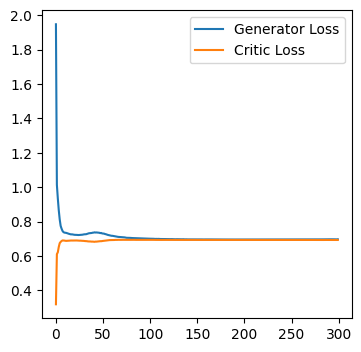

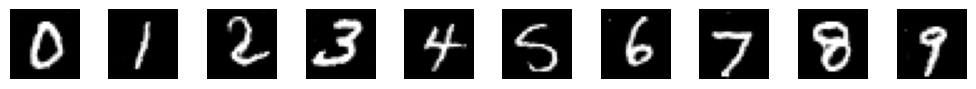

In [942]:
losses_g, losses_d, gen = train_gan(
    epochs=300,
    lr = 2e-4,
    latent_dim = 64
)

In [1408]:
torch.save(gen.state_dict(), 'cgan.ckpt')

---

### 2.3. [5 баллов]
### Формулировка задания:

1. Реализуй функцию `show_grid_gan(...)`, используя шаблон ниже

2. Визуализируй результат для `digit=8, n_reps=9`

3. Добавь код загрузки весов обученной модели, чтобы проверяющему было удобно воспроизвести твой код

In [36]:
@torch.no_grad
def show_grid_gan(model=None, digit=0, n_reps=1, device='cuda'):
    """
    Визуализатор семлов CGAN.
            Параметры:
                    model torch.nn.Module: модель CVAE
                    digit (int): генерируемая цифра
                    n_reps (int): кол-во семплов
                    device torch.device: девайс
            Возвращаемое значение:
                    None
    """
    model.eval()
    with torch.no_grad():
        labels = torch.tensor([digit] * n_reps)
        num_rows = math.ceil(len(labels) / 3)
        fig, axes = plt.subplots(num_rows, 3)
        if num_rows == 1:
            axes = axes.reshape(1, -1)
        samples = generate_samples(model.to(device), labels.to(device), latent_dim=latent_dim, num_samples=n_reps)
        for i, ax in enumerate(axes.flat):
            if i < len(labels):
                ax.imshow(samples[i].view(28, 28).numpy(), cmap='gray')
            ax.axis('off')
        # plt.show()
        plt.tight_layout()
        plt.show()

Пример:

In [37]:
checkpoint = torch.load('cgan.ckpt', map_location='cpu')
latent_dim = 64

gen = Generator(
    latent_dim, emb_dim=10
)
gen.load_state_dict(checkpoint)

/tmp/ipykernel_280368/3315293320.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('cgan.ckpt', map_location='cpu')


<All keys matched successfully>

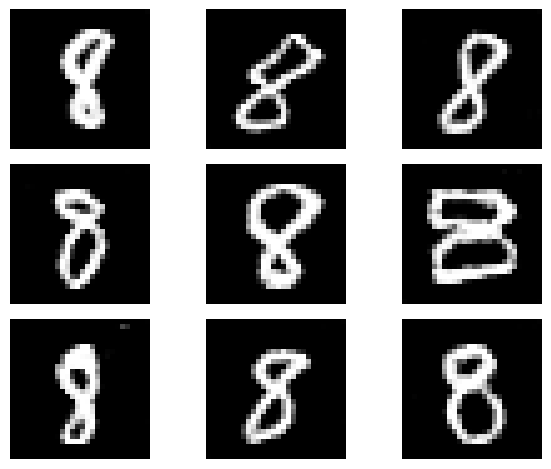

In [43]:
show_grid_gan(
    gen,
    digit=8,
    n_reps=9,
    device=device
)

---

### 2.4. [25 баллов]
### Формулировка задания:

1. Реализуй функцию ```compute_acc_gan(...)```, используя шаблон ниже

2. Выведи результат для `n_reps=100`

Итоговый балл за этот пункт рассчитывается по формуле:

- int(mean_acc * 25), где mean_acc лежит в [0, 1]

In [44]:
import torchvision.transforms as TT
from lenet import LeNet5
import torch

classiffier_model = LeNet5().eval()
classiffier_model.load_state_dict(torch.load('weights/lenet_epoch=12_test_acc=0.991.pth', weights_only=True))
classiffier_model = classiffier_model.to(device)

lenet_transform = TT.Compose([
    TT.Resize(size=(32, 32), antialias=True)
])

In [45]:
@torch.no_grad
def compute_acc_gan(model=None, n_reps=1, device=None):
    """
    CGAN accuracy.
    Алгоритм:
        1. цикл по цифрам
            a. генерируем n_reps цифр с одинаковым лейблом D
            b. считаем accuracy классификатора classiffier_model (в идеале все предикты должны быть D)
            с. сохраняем результат усредненной метрики в буфер

        2. Считаем (mean, std) для получившегося буфера
        3. Возвращаем (mean, std)

            Параметры:
                    model torch.nn.Module: модель CVAE
                    n_reps (int): кол-во семплов
                    device torch.device: девайс
            Возвращаемое значение:
                    (mean, std) (float, float) рассчитаные по цифрам
    """

    model = model.to(device)
    acc = []
    for digit in range(10):
        labels = torch.tensor([digit] * n_reps)
        model.eval()
        labels = labels.to(device)
        samples = generate_samples(model, labels, latent_dim=latent_dim, num_samples=n_reps)
        preds = classiffier_model(lenet_transform(samples.to(device)))
        acc.append((sum(preds.argmax(1) == digit) / n_reps).cpu())
    acc = np.array(acc)
    return acc.mean(), acc.std()

In [413]:
mu, sigma = compute_acc_gan(
    model=gen,
    n_reps=100,
    device=device
)

mu, sigma

(0.982, 0.01989975)

---